In [131]:
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

import os, sys, gc, warnings, random

import datetime
import dateutil.relativedelta

# Data manipulation
import pandas as pd 
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgb

from tqdm.notebook import trange, tqdm

from IPython.display import display

%matplotlib inline

pd.options.display.max_rows = 10000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = 1000

In [18]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
SEED = 42
seed_everything(SEED)

In [132]:
TOTAL_THRES = 300

'''
    입력인자로 받는 year_month에 대해 고객 ID별로 총 구매액이
    구매액 임계값을 넘는지 여부의 binary label을 생성하는 함수
'''
def generate_label(df, year_month, total_thres=TOTAL_THRES, print_log=False):
    df = df.copy()
    
    # year_month에 해당하는 label 데이터 생성
    df['year_month'] = df['order_date'].dt.strftime('%Y-%m')
    df.reset_index(drop=True, inplace=True)

    # year_month 이전 월의 고객 ID 추출
    cust = df[df['year_month']<year_month]['customer_id'].unique()
    # year_month에 해당하는 데이터 선택
    df = df[df['year_month']==year_month]
    
    # label 데이터프레임 생성
    label = pd.DataFrame({'customer_id':cust})
    label['year_month'] = year_month
    
    # year_month에 해당하는 고객 ID의 구매액의 합 계산
    grped = df.groupby(['customer_id','year_month'], as_index=False)[['total']].sum()
    
    # label 데이터프레임과 merge하고 구매액 임계값을 넘었는지 여부로 label 생성
    label = label.merge(grped, on=['customer_id','year_month'], how='left')
    label['total'].fillna(0.0, inplace=True)
    label['label'] = (label['total'] > total_thres).astype(int)

    # 고객 ID로 정렬
    label = label.sort_values('customer_id').reset_index(drop=True)
    if print_log: print(f'{year_month} - final label shape: {label.shape}')
    
    return label

In [133]:
data = pd.read_csv("../input/train.csv", parse_dates=["order_date"])
data=data.drop([433791,433796])
print(data.shape) # data shape 확인
data.head()
df=data.copy()
# df['description']=df['description'].map(lambda x :x.split()[-1])
# df.head()

(780500, 9)


In [184]:
#csv앙상블 - 파일 준비
from collections import Counter
file_list=['/opt/ml/code/output/top1_LGBM.csv',
          '/opt/ml/code/output/try12.csv','/opt/ml/code/output/try16_cat.csv',
          '/opt/ml/code/output/try16_xgb.csv','/opt/ml/code/output/try14.csv',
          '/opt/ml/code/output/try14-1.csv','/opt/ml/code/output/try15-1.csv',
          '/opt/ml/code/output/try15-5.csv']
file_name_list=['top1_LGBM','try12_lgbm','try16_cat','try16_xgb','tabnet1','tabnet2','try15_lgbm','tabnet3(15-5)']

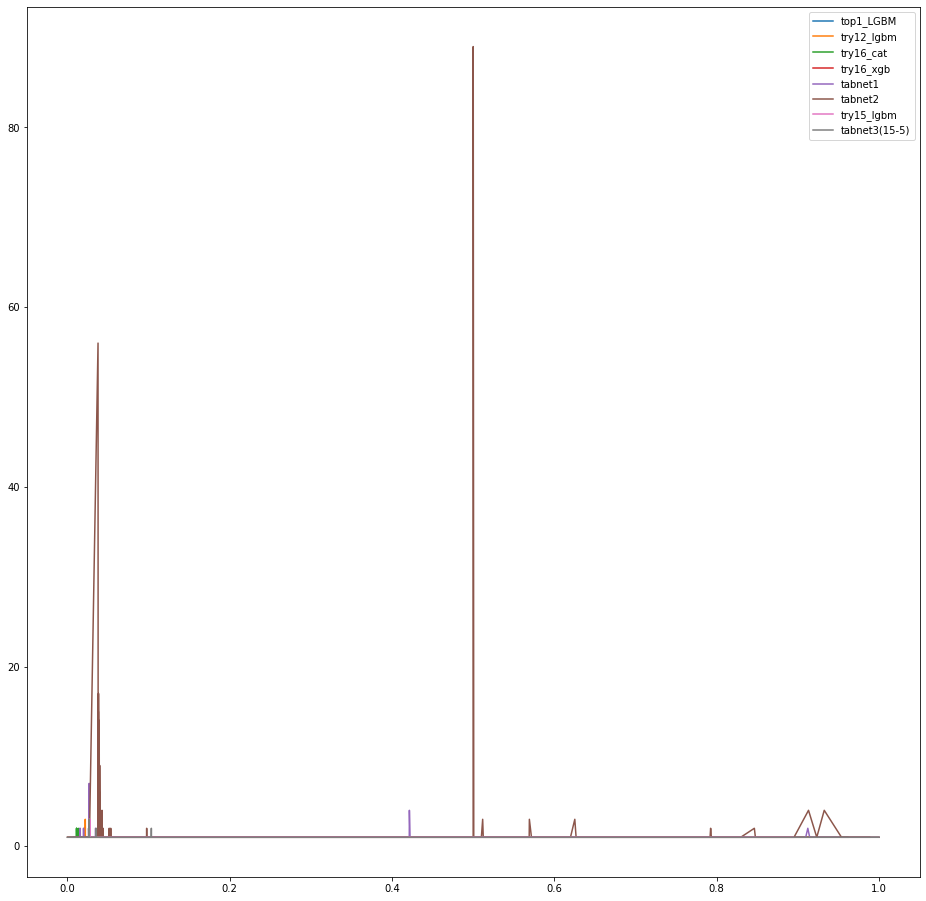

In [185]:
#모델들의 클래스 분포 확인
sample=df.copy()
n=len(file_list)
fig=plt.figure(figsize=(n*2,n*2))
ax_list=[]
for i,file in enumerate(file_list):
    f=pd.read_csv(file)
    c=Counter(f['probability'].values)
    c=sorted(c.items(), key=lambda x : x[0])
    x=[]
    y=[]
    for k ,v in c:
        x.append(k)
        y.append(v)
    plt.plot(x,y, label=file_name_list[i])
    plt.legend()
plt.show()
    

In [186]:
#소프트 보팅 - Counter의 최빈값 이용
answer_list=[]
n=len(file_list)
for i,file in enumerate(file_list):
    f=pd.read_csv(file)
    y=f['probability']
    answer_list.append(y)

answer=[]
for number_answer in zip(*answer_list):
    answer.append(sum(number_answer)/n)

print(len(answer))
# print(answer)
    

5914


In [187]:
###파일 저장###
data_dir = '../input' # os.environ['SM_CHANNEL_TRAIN']
model_dir = '../model' # os.environ['SM_MODEL_DIR']
output_dir = '../output' # os.environ['SM_OUTPUT_DATA_DIR']
sub = pd.read_csv(data_dir + '/sample_submission.csv')
    
# 테스트 예측 결과 저장
sub['probability'] = answer


os.makedirs(output_dir, exist_ok=True)
# 제출 파일 쓰기
sub.to_csv(os.path.join(output_dir , 'ensemble5.csv'), index=False)

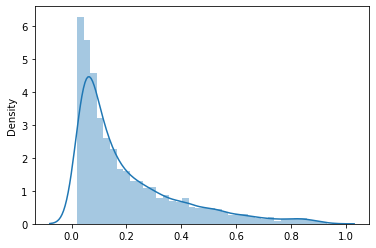

In [188]:
sns.distplot(answer)
plt.show()

In [134]:
dd=df.copy()
dd['month']=dd['order_date'].dt.month
dd['year_month']=dd['order_date'].dt.strftime('%Y-%m')
dd=dd[dd['year_month']<'2011-11']
train_label=generate_label(df,'2011-11')
po3=dd.groupby(['customer_id','year_month'], as_index=False)[['total']].sum()
# .agg({'total': lambda x:1 if x>300 else 0})
po3['o3']=po3.agg({'total': lambda x :1 if x>300 else 0})
relative_po3=po3.groupby(['customer_id'])['o3'].agg('mean')

train_label=train_label.merge(relative_po3,on='customer_id',how='left')
print(train_label.head())


   customer_id year_month      total  label    o3
0        12346    2011-11     0.0000      0  0.00
1        12347    2011-11     0.0000      0  1.00
2        12348    2011-11     0.0000      0  1.00
3        12349    2011-11  2899.9575      1  0.75
4        12350    2011-11     0.0000      0  1.00


In [135]:
pp=po3.groupby(['customer_id']).agg({'total': ['mean','max','min','sum','count','std','skew']})

In [157]:
ppp=train_label
ppp=ppp.merge(pp,on='customer_id',how='left')
ppp.columns=['customer_id','year_month','total','label','o3','total-mean','total-max','total-min','total-sum','total-count','total-std','total-skew']

In [162]:
# ppp.head()
ppp['total-std','total-skew'].fillna(0.0, inplace=True) 
# ppp['total-skew'].fillna(0.0, inplace=True) 
ppp.isna().sum()

KeyError: ('total-std', 'total-skew')

In [141]:
ppp.isna().sum()

customer_id          0
year_month           0
total                0
label                0
o3                   0
(total, mean)        0
(total, max)         0
(total, min)         0
(total, sum)         0
(total, count)       0
(total, std)      1813
(total, skew)     2796
dtype: int64

In [6]:
print(relative_po3.head())

customer_id
12346    0.00
12347    1.00
12348    1.00
12349    0.75
12350    1.00
Name: o3, dtype: float64


In [21]:
num_one=po3.groupby(['customer_id'])['o3'].agg('sum')
# num_whole=po3.groupby(['customer_id'])['o3'].agg('count')
relative_po3=po3.groupby(['customer_id'])['o3'].agg('mean')
absolute_po3=num_one/24
# new_col/=24
new_col2.head()

NameError: name 'new_col2' is not defined

In [ ]:
absolute_po3=new_col/24
relative_po3=new_col3

In [171]:
k=po3.groupby(['customer_id']).agg({'o3': lambda x: x.sum()/len(x)}).head()


In [172]:
round(k,2)

,o3
customer_id,
12346,0.00
12347,1.00
12348,1.00
12349,0.75
12350,1.00


In [169]:
kk=po3.groupby(['customer_id']).agg({'o3': lambda x: round(x.sum()/24,2)}).head(10)
kk=kk.iloc[5:]
round(kk,2)

,o3
customer_id,
12351,0.04
12352,0.17
12353,0.04
12354,0.04
12355,0.08


In [113]:
kk.values[:].squeeze()

array([0.04166667, 0.16666667, 0.04166667, 0.04166667, 0.08333333])

In [116]:
# kkk=pd.concat([k,kk.squeeze()],axis=1,keys='customer_id')
k['o2','o4']=kk.values[:].squeeze(),kk.values[:].squeeze()
k

ValueError: Length of values (2) does not match length of index (5)

In [114]:
pd.concat([df.head(),kk.values[:].squeeze()],axis=1)

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

In [53]:
kk

,o3
customer_id,
12346,0.000000
12347,0.291667
12348,0.208333
12349,0.125000
12350,0.041667
